In [1]:
import logging
from typing import List, Callable, Optional, Any

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.decomposition import PCA


from pynamics import downsample, downsample_split, avg_over, get_attractor_dimension
from pynamics.utils import np_cache, eigsort

from randnn import ScaleFreeNN, scaling_analysis
from hoogland_masters.plotting import *

rc('text', usetex=True)
logging.basicConfig(level=logging.ERROR)

## The model
$$\tau \frac{dh_i}{dt}=-h_i+\sum_{j=1}^N J_{ij}\phi(h_j),$$

#### "Fixed" Parameters
- $\tau$ is the characteristic timescale ($:=1$).
- $h_i$ is the activation of neuron $i$.
- $J_{ij}\sim \mathcal N(0, g^2/N)$ is the coupling matrix.
- $\phi$ is the activation function ($=\tanh$).

####  "Loose" Parameters
- $N$ is the number of neurons.
- $g$ is the coupling strength.
- $k$ is the degree of the nodes
    - $P(k) = c k^{-\alpha}$
    - $c$ is the normalization factor: $c=\sum_{k_\text{min}}^{k_\text{max}} k^{-\alpha}$. 
    - $\alpha$ is the power-law coefficient (i.e., the fraction of edges to dilute to zero).


## How to compare sparse networks to dense networks?
1. **Vary $\alpha$. Fix $k_\text{min}$ & $k_\text{max}$
2. **Vary $\alpha$. Hold $k_\text{avg}$ constant by varying either $k_\text{min}$ or $k_\text{max}$

In [2]:
# Shared parameters
N_STEPS = 100000
N_DOFS = 200

TIMESTEP = 0.1
N_BURNIN_STEPS = 500
DOWNSAMPLE_RATE = 100

In [3]:
rc('text', usetex=False)

def get_lyapunov_spectrum(trajectory, system):
    n_dofs = trajectory.shape[1]
    return np.arange(n_dofs)/n_dofs, np.sort(system.get_lyapunov_spectrum(trajectory[::DOWNSAMPLE_RATE], t_ons=100))[::-1]

def measure_over_range(
        param_range: List[dict],
        observable: Callable[[np.ndarray, ScaleFreeNN], np.ndarray],
        n_steps: int = 10000,
        n_burn_in: int = 1000,
    **kwargs
):
    """
    A helper function for plotting vector measurements across ranges of
    coupling strength values. Each measurement will be plotted as a single curve.
:param observable: A function which takes a generated trajectory and
        the Trajectory object that generated it, and computes a
        measurement on it.
    :param n_dofs: The number of elements (neurons).
    :param n_steps: How many timesteps to simulate for each
        coupling_strength.
    :param n_burn_in: How many burnin timesteps to simulate before
        starting to record.
    :param kwargs:
    """
    results = []
    
    for i, params in enumerate(param_range):
        
        # 1. Initialize a network
        rand_nn = ScaleFreeNN(**params,
                               **kwargs)

        # 2. Simulate a phase space trajectory
        trajectory = rand_nn.run(n_steps=n_steps, n_burn_in=n_burn_in)

        # 3. Perform your measurement
        measurement_range, measurement = observable(trajectory, rand_nn)

        label = ", ".join(list(map(lambda vals: f"{vals[0]} {vals[1]}", params.items())))
        results.append([measurement_range, measurement, f"{i}. {label}"])

    return results


def plot_lyap_spec_over_range(params_range, **kwargs):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    results = measure_over_range(params_range, get_lyapunov_spectrum, **kwargs)

    for [x, y, label] in results:
        ax.plot(x, y, label=label)

    ax.set_title(f"$g={kwargs['coupling_strength']}$")
    ax.set_ylabel("$\lambda_i$")
    ax.set_xlabel("$i$")
    ax.legend()
    
    del results

def plot_lyap_spec_over_double_range(outside_range, inside_range, **kwargs):
    for outside_params in outside_range:
        results = plot_lyap_spec_over_range(inside_range, **outside_params, **kwargs)
        plt.show()
    

## Shared parameters

In [4]:
ALPHAS = [0., 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
ALPHAS_RANGE = list(map(lambda alpha: {"alpha": alpha}, ALPHAS))
GS_RANGE = list(map(lambda g: { "coupling_strength": g}, [1.5, 2., 3.])) # , 5., 10., 20.]))

# TODO: Make sure there are non disconnected components
# -> sample one edge in one component & one edge in another & make edges cross the component.
MIN_DEGREE = 1
MAX_DEGREE = N_DOFS

## 1. Vary $\alpha$, constant $g$ & $N$

Generating samples: 100%|██████████| 100000/100000 [00:55<00:00, 1786.19it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 1000it [00:00, 2150.22it/s]
Generating samples: 100%|██████████| 100000/100000 [00:39<00:00, 2515.61it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 1000it [00:00, 2138.89it/s]
Generating samples: 100%|██████████| 100000/100000 [00:35<00:00, 2802.06it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 1000it [00:00, 2013.67it/s]
Generating samples: 100%|██████████| 100000/100000 [00:35<00:00, 2805.57it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 1000it [00:00, 1950.91it/s]
Generating samples: 100%|██████████| 100000/100000 [00:36<00:00, 2743.18it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 1000it [00:00, 2195.00it/s]
Generating samples: 100%|██████████| 100000/100000 [00:35<00:00, 2823.

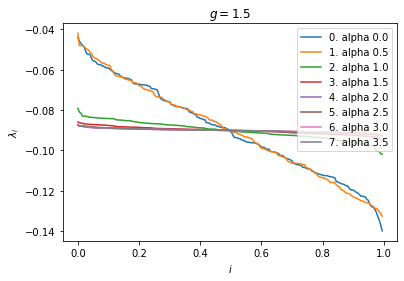

In [5]:
plot_lyap_spec_over_double_range(GS_RANGE[:1], ALPHAS_RANGE, n_dofs=N_DOFS, n_steps=N_STEPS, normalize_strength=False)

## 2. Vary $\alpha$, constant $\text{std}(J_{ij})$

Generating samples: 100%|██████████| 100000/100000 [00:37<00:00, 2632.27it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 1000it [00:00, 1652.60it/s]
Generating samples: 100%|██████████| 100000/100000 [00:37<00:00, 2694.81it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 1000it [00:00, 1471.67it/s]
Generating samples: 100%|██████████| 100000/100000 [00:38<00:00, 2597.72it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 1000it [00:00, 2258.11it/s]
Generating samples: 100%|██████████| 100000/100000 [00:38<00:00, 2603.51it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 1000it [00:00, 2122.60it/s]


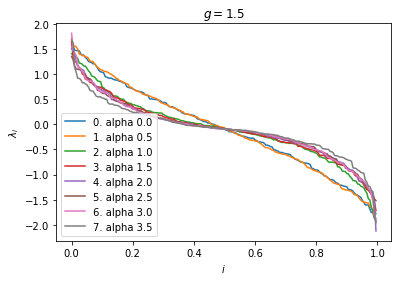

Generating samples: 100%|██████████| 100000/100000 [00:37<00:00, 2659.90it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 1000it [00:00, 1611.63it/s]
Generating samples: 100%|██████████| 100000/100000 [00:54<00:00, 1849.46it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 1000it [00:00, 1095.03it/s]
Generating samples: 100%|██████████| 100000/100000 [01:13<00:00, 1351.60it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 1000it [00:00, 2218.26it/s]
Generating samples: 100%|██████████| 100000/100000 [00:36<00:00, 2718.05it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 1000it [00:00, 1373.89it/s]
Generating samples: 100%|██████████| 100000/100000 [00:37<00:00, 2691.30it/s]
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 1000it [00:00, 2027.03it/s]
Generating samples: 100%|██████████| 100000/100000 [00:37<00:00, 2672.

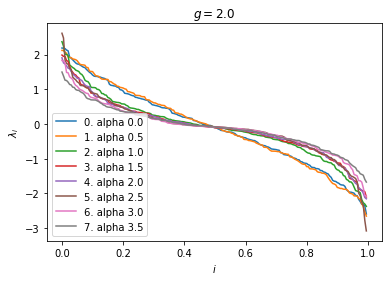

In [6]:
plot_lyap_spec_over_double_range(GS_RANGE[:2], ALPHAS_RANGE, n_dofs=N_DOFS, n_steps=N_STEPS, normalize_strength=True)

## Appendix

Other things to do:

In [7]:
# Compare exact same network architectures and relative weights, vary only absolute coupling strength.